# Score

> Scoring functions to calculate kinase score based on substrate sequence

## Setup

In [ ]:
#| default_exp score

In [ ]:
#| export
import numpy as np, pandas as pd
from katlas.data import *
from katlas.utils import *
from katlas.pssm import *
from typing import Callable
from functools import partial

from tqdm.contrib.concurrent import process_map
from tqdm import tqdm

```python
from katlas.score import *
```

## Utils

In [ ]:
#| export 
def cut_seq(input_string: str, # site sequence
            min_position: int, # minimum position relative to its center
            max_position: int, # maximum position relative to its center
            ):
    
    "Extract sequence based on a range relative to its center position"
    
    # Find the center position of the string
    center_position = len(input_string) // 2

    # Calculate the start and end indices
    start_index = max(center_position + min_position, 0)  # Ensure start_index is not negative
    end_index = min(center_position + max_position + 1, len(input_string))  # Ensure end_index does not exceed string length

    # Extract and return the substring
    return input_string[start_index:end_index]

In [ ]:
cut_seq('AAkUuPSFSTtH',-5,4)

'AkUuPSFSTt'

In [ ]:
#| export
def STY2sty(input_string: str):
    "Replace all 'STY' with 'sty' in a sequence"    
    return input_string.replace('S', 's').replace('T', 't').replace('Y', 'y')

In [ ]:
STY2sty('AAkUuPSFSTtH') # convert all capital STY to sty in a string

'AAkUuPsFsttH'

In [ ]:
#| export
def get_dict(input_string:str, # phosphorylation site sequence
            ):
    
    "Get a dictionary of input string; no need for the star in the middle; make sure it is 15 or 10 length"

    center_index = len(input_string) // 2
    center_char = input_string[center_index]

    result = []

    for i, char in enumerate(input_string):
        position = i - center_index

        if char.isalpha():
            result.append(f"{position}{char}")

    return result

In [ ]:
cols = get_dict("PSVEPPLsQETFSDL")
cols

['-7P',
 '-6S',
 '-5V',
 '-4E',
 '-3P',
 '-2P',
 '-1L',
 '0s',
 '1Q',
 '2E',
 '3T',
 '4F',
 '5S',
 '6D',
 '7L']

## Algorithms

### Multiply

In [ ]:
#| export
def multiply_func(values, # list of values, possibilities of amino acids at certain positions
             factor=17, # scale factor
            ):
    
    "Multiply the possibilities of the amino acids at each position in a phosphorylation site"
    

    # Using the logarithmic property: log(a*b) = log(a) + log(b)
    # Compute the sum of the logarithms of the values and the scale factor
    log_sum = np.sum(np.log2(values)) + (len(values) - 1) * np.log2(factor)

    return log_sum

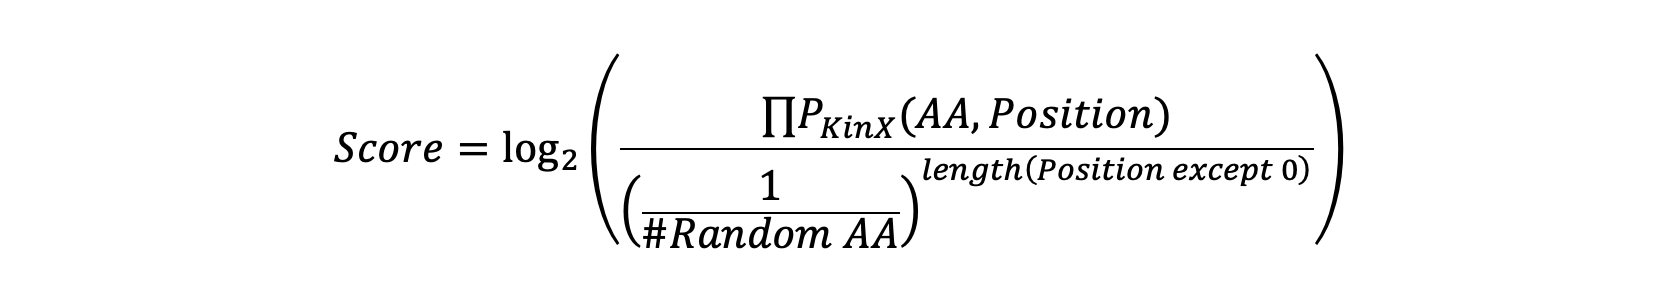

The function implement formula from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome, Supplementary Note2](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-05575-3/MediaObjects/41586_2022_5575_MOESM1_ESM.pdf) (page 160)

Multiply class, consider the dynamics of scale factor

In [ ]:
#| export
def multiply(values, kinase, num_dict=Data.get_num_dict()):
    "Multiply values, consider the dynamics of scale factor, which is PSPA random aa number."

    # Check if any values are less than or equal to zero
    if np.any(np.array(values) == 0):
        return np.nan
    else:
        # Retrieve the divide factor from the dictionary
        divide_factor = num_dict[kinase]

        # Using the logarithmic property: log(a*b) = log(a) + log(b)
        # Compute the sum of the logarithms of the values and the divide factor
        log_sum = np.sum(np.log2(values)) + (len(values) - 1) * np.log2(divide_factor)

        return log_sum

In [ ]:
multiply(values=[1,2,3,4,5],kinase='PDHK1')

22.906890595608516

### Log odds

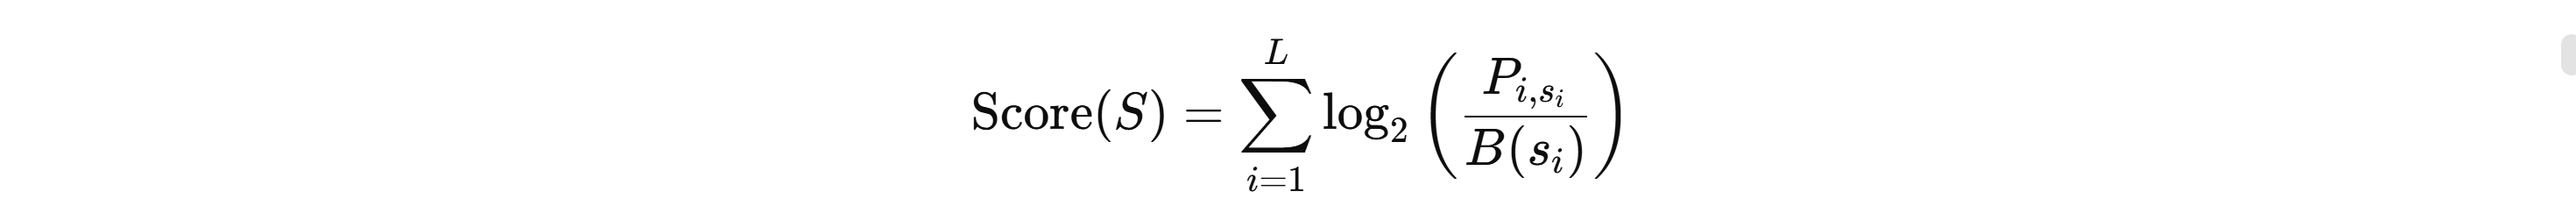

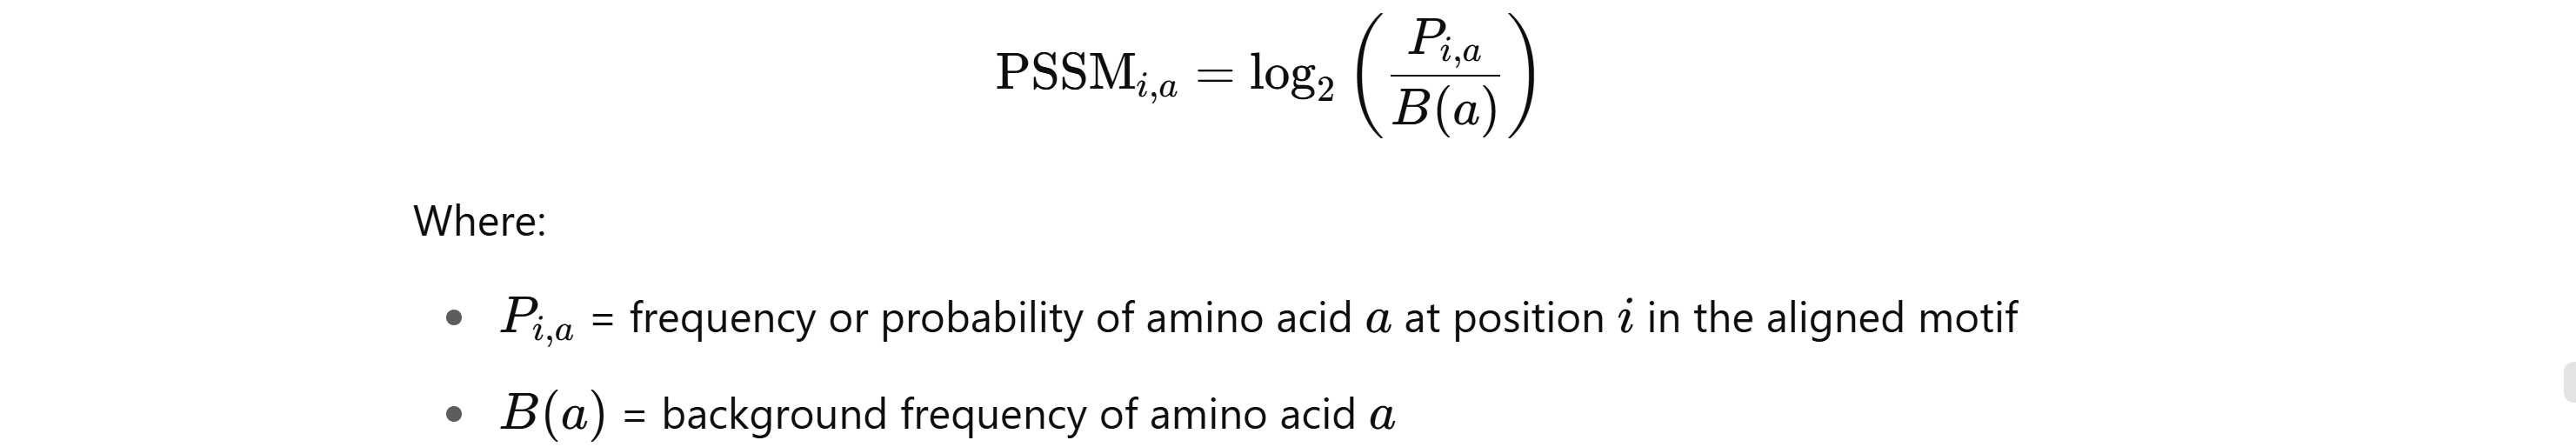

### Background frequencies

In [ ]:
# import json

# # Save
# with open('cddm_pssms.json', 'w') as f:
#     json.dump(pssms_dict, f)

In [ ]:
pssms = Data.get_cddm()

In [ ]:
pssms_dict = pssms.to_dict(orient='index')

In [ ]:
# with open('cddm_pssms.json', 'r') as f:
#     pssms_dict = json.load(f)

In [ ]:
#| export
def get_pos_range(pssms_dict):
    "Get min and max position given a pssms_dict."
    one_pssm = next(iter(pssms_dict.values()))
    values = set([int(k[:-1]) for k in one_pssm.keys()])
    return min(values),max(values)

In [ ]:
get_pos_range(pssms_dict)

(-7, 7)

In [ ]:
#| export
def cut_seq_on_pssms(site_seq,pssms_dict):
    "Based on one pssm from pssms_dict, cut site seq if it is out of bound."
    
    min_pos,max_pos= get_pos_range(pssms_dict)
    print(f'Let sequence be within the position range of reference PSSMs: {min_pos} to +{max_pos}.')
    return cut_seq(site_seq,min_pos,max_pos)

In [ ]:
cut_seq_on_pssms('SSSSSPSVEPPLsQETFSDLSSSSS',pssms_dict)

Let sequence be within the position range of reference PSSMs: -7 to +7.


'PSVEPPLsQETFSDL'

In [ ]:
#| export
def cut_seq_on_pssms_df(df,seq_col,pssms_dict):
    "Based on one pssm from pssms_dict, cut sequences in a df if it is out of bound."
    min_pos,max_pos= get_pos_range(pssms_dict)
    print(f'Let sequence be within the position range of reference PSSMs: {min_pos} to +{max_pos}.')
    return df[seq_col].apply(partial(cut_seq, min_position=min_pos, max_position=max_pos))

In [ ]:
human = Data.get_human_site()

In [ ]:
cut_seq_on_pssms_df(human,'site_seq',pssms_dict)

Let sequence be within the position range of reference PSSMs: -7 to +7.


0         ITGSRLLsMVPGPAR
1         VDDEKGDsNDDYDSA
2         YDSAGLLsDEDCMSV
3         IADHLFWsEETKSRF
4         KSRFTEYsMTssVMR
               ...       
121327    EGGAGDRsEEEAsst
121328    DRsEEEAsstEKPtK
121329    RsEEEAsstEKPtKA
121330    sEEEAsstEKPtKAL
121331    AsstEKPtKALPRKS
Name: site_seq, Length: 119955, dtype: object

In [ ]:
#| export
def calculate_log_odds(cut_seq, # site sequence to be scored
                        pssms_dict,# key as kinase and value as flattened pssm
                       site_type=None,
                       bg_pssm=None,
                        sort=True,
                       ):
    "Calculate log odds based on cut sequence within the reference pssm range."
    bg_df = Data.get_ks_background()
    if site_type is not None: bg_pssm = bg_df.loc[f'ks_{site_type.upper()}'].copy()
    elif bg_pssm is not None: bg_pssm = bg_pssm.copy()
    else:
        acceptor_pos = len(cut_seq)//2
        acceptor=cut_seq[acceptor_pos]
        bg_pssm = bg_df.loc[f'ks_{acceptor.upper()}'].copy()
    
    pos_aa_keys = get_dict(cut_seq)
    out = {}
    for k,flatten_pssm in pssms_dict.items(): 
        # if the flatten pssm value got zero, it will leads to -inf
        score = sum([np.log2((flatten_pssm[pos_aa] + 1e-5)/(bg_pssm[pos_aa]+1e-5)) for pos_aa in pos_aa_keys])
        out[k]=score
    
    return pd.Series(out).sort_values(ascending=False) if sort else pd.Series(out)

In [ ]:
calculate_log_odds('PSVEPPLsQETFSDL',pssms_dict)

ATR      13.379067
ATM      11.133979
DNAPK     6.591411
CDK8      1.854333
TSSK1     1.621422
           ...    
LIMK2   -20.450229
CDK3    -21.398831
SLK     -23.802818
MRCKB   -26.362947
PERK    -27.007599
Length: 289, dtype: float64

In [ ]:
#| export
def get_kinase_log_odds(site_seq, # site sequence to be scored
                        pssms_dict,# key as kinase and value as flattened pssm
                        **kwargs
                       ):
    "Calculate kinase score of a site sequence given pssms_dict and background pssm."
    seq = check_seq(site_seq)
    cut_seq = cut_seq_on_pssms(seq,pssms_dict)
    return calculate_log_odds(cut_seq,pssms_dict=pssms_dict,**kwargs)

In [ ]:
check_seq('PSVEPPLsQETFSDL')

'PSVEPPLsQETFSDL'

In [ ]:
get_kinase_log_odds('PSVEPPLsQETFSDL',pssms_dict)

Let sequence be within the position range of reference PSSMs: -7 to +7.


ATR      13.379067
ATM      11.133979
DNAPK     6.591411
CDK8      1.854333
TSSK1     1.621422
           ...    
LIMK2   -20.450229
CDK3    -21.398831
SLK     -23.802818
MRCKB   -26.362947
PERK    -27.007599
Length: 289, dtype: float64

In [ ]:
#| export
def check_seqs(seqs:pd.Series):
    "Convert non-s/t/y to upper case & replace with underscore if the character is not in the allowed set"
    assert len(seqs.str.len().value_counts())==1, 'inconsistent sequence length detected'
    return seqs.apply(check_seq)

In [ ]:
#| export
def get_kinase_log_odds_df(df, seq_col, # site sequence to be scored
                        pssms_dict,# key as kinase and value as flattened pssm
                           parallel=True, # use parallel processing if True
                           sort=False,
                        **kwargs
                           
                       ):
    "Calculate kinase score of sequences in a df given pssms_dict and background pssm."
    cut_seqs = cut_seq_on_pssms_df(df, seq_col,pssms_dict)
    checked_cut_seqs = check_seqs(cut_seqs)
    
    if parallel:
        wrapper = partial(calculate_log_odds, sort=sort,**kwargs)
        results = process_map(wrapper, checked_cut_seqs,chunksize=100)
        return pd.DataFrame(results)
    else:
        return pd.DataFrame([calculate_log_odds(seq,pssms_dict,sort=sort,**kwargs) for seq in tqdm(checked_cut_seqs)])

In [ ]:
get_kinase_log_odds_df(human.head(10),'site_seq',pssms_dict,parallel=False)

Let sequence be within the position range of reference PSSMs: -7 to +7.



100%|██████████| 10/10 [00:00<00:00, 81.17it/s][A


,SRC,EPHA3,FES,NTRK3,ALK,EPHA8,ABL1,FLT3,EPHB2,FYN,...,MEK5,PKN2,MAP2K7,MRCKB,HIPK3,CDK8,BUB1,MEKK3,MAP2K3,GRK1
0,-6.834939,-6.226365,-7.695221,-5.778931,-6.748094,-7.305816,-4.949184,-6.795048,-6.780491,-7.430980,...,-13.751513,-6.700875,0.664614,-11.965351,-8.269410,-15.987455,-3.024525,-12.537066,2.067269,-34.978009
1,-2.787712,-2.184116,-2.030497,-3.016946,-2.795443,-1.633924,-3.606747,-3.197927,-2.535484,-1.439454,...,-9.929361,-13.842463,-10.501498,-8.838672,-28.157528,-7.236805,-12.967786,-10.855866,-9.532418,-20.914510
2,-4.400023,-3.880026,-3.600108,-3.433173,-4.822332,-5.214294,-5.780404,-6.425483,-4.559895,-4.087982,...,-34.949360,-20.840285,-27.924034,-39.232552,-13.082519,-21.271829,-16.060199,-15.896029,-26.803760,-10.950010
3,-1.858100,-2.077535,-3.137042,-1.826046,-2.842460,-3.105884,-2.904125,-2.888445,-2.601997,-2.483656,...,-7.028202,6.532928,-0.672702,-28.807424,-44.272850,-11.192035,-10.501577,-21.918909,-9.375008,-5.354777
4,-7.846949,-9.211063,-10.707947,-10.049246,-11.106238,-10.004203,-8.335588,-17.250129,-11.380093,-10.607860,...,-45.751185,-33.215923,-7.332241,-30.562655,-44.583823,-36.421097,-24.849370,-48.512109,-31.798307,-44.706866
5,-5.573933,-6.375702,-6.180108,-5.660873,-6.094550,-6.110192,-5.577982,-6.640383,-6.049525,-5.108223,...,-24.883888,-25.395896,-10.664401,-21.363969,-23.513679,-24.974486,-9.292972,-23.527402,-17.512193,-40.701488
6,-8.135098,-6.596200,-8.303372,-7.374844,-6.232523,-7.147063,-6.242102,-5.788387,-7.126718,-7.285538,...,-12.880634,-25.752945,-20.574576,-39.697786,-33.637365,-31.118501,-36.537491,-24.841079,-17.103741,-32.904123
7,-8.618104,-11.024002,-10.093951,-9.237905,-9.946672,-11.984708,-9.190825,-9.362905,-9.830988,-9.136566,...,-16.486060,-12.437818,1.196805,-17.744377,3.511220,-22.600149,-4.465207,-16.292567,0.798599,-15.486682
8,-6.127544,-7.267991,-7.159930,-5.897895,-6.461399,-7.633443,-5.801562,-7.011265,-7.294982,-6.769097,...,-3.700738,1.147968,-0.781214,-1.852455,-3.598562,-4.785045,-3.083286,-1.962302,-2.607863,-17.613164
9,-2.679757,-3.688841,-3.617050,-2.983916,-3.287914,-3.672047,-2.311731,-2.951490,-2.286616,-2.913383,...,-35.733420,-6.279436,-16.687181,-18.868566,-4.874849,-38.264279,-10.590697,-15.189655,-10.709765,-39.215480


### Sum

In [ ]:
#| export
def sumup(values, # list of values, possibilities of amino acids at certain positions
          kinase=None, 
         ):
    "Sum up the possibilities of the amino acids at each position in a phosphorylation site sequence"
    return sum(values)

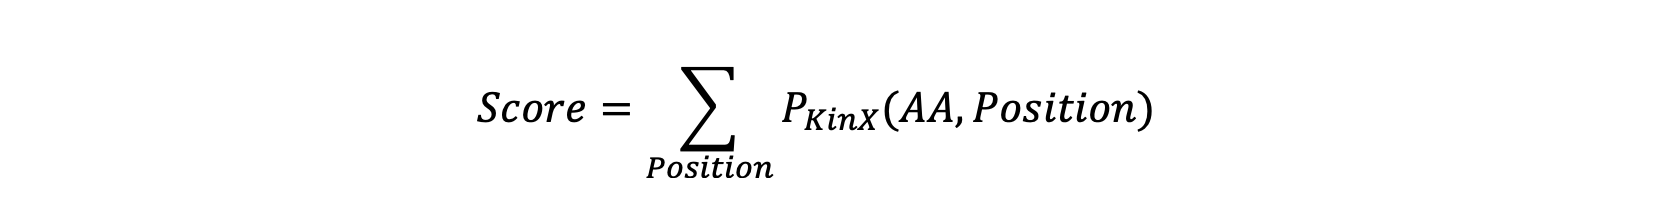

## Scoring func

In [ ]:
#| export
def predict_kinase(input_string: str, # site sequence
                   ref: pd.DataFrame, # reference dataframe for scoring
                   func: Callable, # function to calculate score
                   to_lower: bool=False, # convert capital STY to lower case
                   to_upper: bool=False, # convert all letter to uppercase
                   verbose=True
                   ):
    "Predict kinase given a phosphorylation site sequence"
 
    input_string = check_seq(input_string)

    if to_lower:
        input_string = STY2sty(input_string)

    if to_upper:
        input_string = input_string.upper()

    # if ref contains pS,pT,pY columns, convert them to s,t,y for scoring
    ref=ref.copy()
    ref.columns=ref.columns.map(pSTY2sty)
    
    results = []
    
    for kinase, row in ref.iterrows():
        
        # Convert the row into a dictionary, excluding NaN values, to create a PSSM dictionary for a kinase
        r_dict = row.dropna().to_dict()
        
        # Extract position+amino acid name from the input string and filter them against the name in PSSM
        pos_aa_name = get_dict(input_string)
        pos_aa_name = [key for key in pos_aa_name if key in r_dict.keys()]
    
        # Collect corresponding PSSM values for these positions and amino acids
        pos_aa_val = [r_dict[key] for key in pos_aa_name] # Further checks for NaN values
        
        # Calculate the score for this kinase using the specified function
        score = func(pos_aa_val, kinase)
        results.append(score)
    
    if verbose:
        print(f'considering string: {pos_aa_name}')

    out = pd.Series(results, index=ref.index).sort_values(ascending=False)
        
    return out.round(3).dropna()

In [ ]:
pspa_scale = Data.get_pspa_all_scale()

In [ ]:
predict_kinase("PSVEPPLsQETFSDL",pspa_scale,multiply)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F']


kinase
ATM        0.167
SMG1      -0.060
DNAPK     -0.714
FAM20C    -1.216
ATR       -1.321
           ...  
PKCI     -11.319
NEK3     -11.455
CK1A     -11.686
CK1G3    -13.182
CK1G2    -13.421
Length: 303, dtype: float64

In [ ]:
ref = Data.get_pspa_st_norm().astype('float32')

In [ ]:
predict_kinase("PSVEPPLsQETFSDL",ref,multiply)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F']


kinase
ATM       5.037
SMG1      4.385
DNAPK     3.818
ATR       3.507
FAM20C    3.170
          ...  
PKN1     -7.275
P70S6K   -7.295
AKT3     -7.375
PKCI     -7.742
NEK3     -8.254
Length: 303, dtype: float64

## Params

Here we provide different PSSM settings from either PSPA data or kinase-substrate dataset for kinase prediction:

In [ ]:
#| export
def Params(name=None):
    params = {
        "PSPA_st": {'ref': Data.get_pspa_st_norm().astype('float32'), 'func': multiply},
        "PSPA_y": {'ref': Data.get_pspa_tyr_norm().astype('float32'), 'func': multiply},
        "PSPA": {'ref': Data.get_pspa_all_norm().astype('float32'), 'func': multiply},
        "CDDM": {'ref': Data.get_cddm().astype('float32'), 'func': sumup},
        "CDDM_upper": {'ref': Data.get_cddm_upper().astype('float32'), 'func': sumup, 'to_upper': True},
    }
    
    if name is None:
        print("Available parameter sets:")
        return list(params.keys())
    
    if name in params:
        return params[name]
    
    raise ValueError(f"Unknown parameter set: {name}. Use Params() to list available options.")

In [ ]:
Params()

Available parameter sets:


['PSPA_st', 'PSPA_y', 'PSPA', 'CDDM', 'CDDM_upper']

In [ ]:
for p in ['PSPA', 'CDDM','CDDM_upper']:
    print(predict_kinase("PSVEPPLsQETFSDL",**Params(p)).head())

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F', '5S']
kinase
ATM       5.037
SMG1      4.385
DNAPK     3.818
ATR       3.507
FAM20C    3.170
dtype: float64
considering string: ['-7P', '-6S', '-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F', '5S', '6D', '7L']
kinase
ATR      3.064
ATM      2.909
DNAPK    2.270
CK2A1    1.873
TSSK1    1.856
dtype: float64
considering string: ['-7P', '-6S', '-5V', '-4E', '-3P', '-2P', '-1L', '0S', '1Q', '2E', '3T', '4F', '5S', '6D', '7L']
kinase
ATR      3.229
ATM      3.038
DNAPK    2.479
CK2A1    2.006
CDK8     1.999
dtype: float64


## Score sequences in df

In [ ]:
cut_seq('AAkUuPSFSTtH',-50,40)

'AAkUuPSFSTtH'

In [ ]:
#| export
def predict_kinase_df(df, seq_col, ref, func, to_lower=False, to_upper=False):
    
    print('input dataframe has a length', df.shape[0])
    print('Preprocessing')
    
    df = df.copy()
    
    df[seq_col] = check_seq_df(df, seq_col)
    
    if to_lower:
        df[seq_col] = df[seq_col].apply(STY2sty)
        
    if to_upper:
        df[seq_col] = df[seq_col].str.upper()
        
    # Adjust sequence lengths to match the reference matrix's expected inputs
    # Cut only work when ref is shorter than the input sequence
    max_value = ref.columns.str[:-1].astype(int).max() # Get the highest position index from the reference columns
    min_value = ref.columns.str[:-1].astype(int).min() # Get the lowest position index
    df[seq_col] = df[seq_col].apply(partial(cut_seq, min_position=min_value, max_position=max_value))
    
    print('Finish preprocessing')
    
    
    # wide form to long form
    df['keys'] = df[seq_col].apply(get_dict)
    input_keys_df  = df[['keys']].explode('keys').reset_index()
    input_keys_df.columns = ['input_index', 'key']
    
    
    ref_T = ref.T
    
    input_keys_df = input_keys_df.set_index('key')
    
    
    print('Merging reference')
    merged_df = input_keys_df.merge(ref_T, left_index=True, right_index=True, how='inner')

    print('Finish merging')
    
    if func == sumup:
        grouped_df = merged_df.groupby('input_index').sum()
        out = grouped_df.reindex(df.index)
         
    elif func==multiply:
        # Get the list of kinases and num_dict
        kinases = ref_T.columns
        num_dict = Data.get_num_dict()
        
        out = {}
        for kinase in tqdm(kinases):
            divide_factor = num_dict[kinase]
            # Extract data for this kinase
            kinase_df = merged_df[['input_index', kinase]].copy()
            kinase_df = kinase_df.rename(columns={kinase: 'value'})

            # Compute log_value
            kinase_df['log_value'] = np.log2(kinase_df['value'].where(kinase_df['value'] > 0))

            # Group by 'input_index' and compute sum and count
            grouped = kinase_df.dropna().groupby('input_index')
            sum_log_values = grouped['log_value'].sum()
            len_values = grouped['log_value'].count()

            # Compute log_sum using the formula
            log_sum = sum_log_values + (len_values - 1) * np.log2(divide_factor)

            # Find all 'input_index' where 'log_value' is NaN
            nan_input_indices = kinase_df.loc[kinase_df['value']==0, 'input_index'].unique()
            # Set log_sum at those indices to NaN
            log_sum.loc[nan_input_indices] = np.nan

            # Assign the computed values to the results DataFrame
            out[kinase] = log_sum

        out = pd.DataFrame(out).reindex(df.index)
        
    else:
        grouped_df = merged_df.drop(columns=['key']).groupby('input_index').agg(func)
        out = grouped_df.reindex(df.index)
        
    # Get results as a DataFrame
    return out

In [ ]:
df = Data.get_psp_human_site()
df_sty = df[df['site_seq'].str[7].isin(list('sty'))]

In [ ]:
%%time
out_cddm = predict_kinase_df(df_sty.head(500),'site_seq', **Params('CDDM'))

input dataframe has a length 500
Preprocessing
Finish preprocessing
Merging reference
Finish merging
CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 39.9 ms


## Percentile scoring

In [ ]:
#| export
def get_pct(site,ref,func,pct_ref):
    
    "Replicate the precentile results from The Kinase Library."
    
    # As here we try to replicate the results, we use site.upper(); consider removing it for future version.
    score = predict_kinase(site.upper(),ref=ref,func=func)
    
    percentiles = {}
    for kinase in score.index: 
        # Get the values from `ref` for this kinase
        ref_values = pct_ref[kinase].values
        # Calculate how many values in `ref` are less than the new score
        less = np.sum(ref_values < score[kinase])
        # Calculate how many values are equal to the new score
        equal = np.sum(ref_values == score[kinase])
        # Calculate the percentile rank
        percentile = (less + 0.5 * equal) / len(ref_values) * 100
        percentiles[kinase] = percentile
        
    pct = pd.Series(percentiles)
    final = pd.concat([score,pct],axis=1)
    final.columns=['log2(score)','percentile']
    return final

In [ ]:
st_pct = Data.get_pspa_st_pct()
y_pct = Data.get_pspa_tyr_pct()

In [ ]:
out = get_pct('PSVEPPLyQETFSDL',**Params('PSPA_y'), pct_ref=y_pct)
out.sort_values('percentile',ascending=False)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0Y', '1Q', '2E', '3T', '4F', '5S']


,log2(score),percentile
ABL2,3.137,96.568694
BMX,2.816,96.117567
BTK,1.956,95.693780
CSK,2.303,95.174299
MERTK,2.509,93.588517
...,...,...
FLT1,-1.919,25.358852
PINK1_TYR,-1.227,21.927546
MUSK,-3.031,21.298701
TNNI3K_TYR,-3.549,11.004785


In [ ]:
get_pct('PSVEPPLsQETFSDL',**Params('PSPA_st'), pct_ref=st_pct)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0S', '1Q', '2E', '3T', '4F']


,log2(score),percentile
ATM,5.037,99.822351
SMG1,4.385,99.831819
DNAPK,3.818,99.205315
ATR,3.507,99.680344
FAM20C,3.170,95.370556
...,...,...
PKN1,-7.275,14.070436
P70S6K,-7.295,4.089816
AKT3,-7.375,11.432995
PKCI,-7.742,8.129511


In [ ]:
#| export
def get_pct_df(score_df, # output from predict_kinase_df 
               pct_ref, # a reference df for percentile calculation
              ):
    
    "Replicate the precentile results from The Kinase Library."

    # Create an array to hold percentile ranks
    percentiles = np.zeros(score_df.shape)
    
    # Calculate percentiles for each column in a vectorized manner
    for i, kinase in tqdm(enumerate(score_df.columns),total=len(score_df.columns)):
        ref_values = np.sort(pct_ref[kinase].values)
        
        # Use searchsorted to find indices where the scores would be inserted to maintain order
        indices = np.searchsorted(ref_values, score_df[kinase].values, side='right')
        
        # Calculate percentile ranks
        percentiles[:, i] = indices / len(ref_values) * 100

    # Convert the array to a DataFrame with appropriate indices and columns
    percentiles_df = pd.DataFrame(percentiles, index=score_df.index, columns=score_df.columns).astype(float).round(3)
    
    return percentiles_df

In [ ]:
# substrate score first
# score_df = predict_kinase_df(df_sty,'site_seq', **Params('PSPA_st'))

# get percentile reference
# pct_ref = Data.get_pspa_st_pct()

In [ ]:
# pct = get_pct_df(score_df,pct_ref)

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()